# Bitmap Operations

- Bitmap Conversion to RowId : Converts the bitmaps to the corresponding RowIds
- Bitmap Conversion From RowId: Generates a bitmap index from b-tree
- Bitmap Conversion Count: Calculates the count by using the index
- Bitmap Index Single Value : Gets a single value by using the index
- Bitmap Range Scan : Performs a range scan over the bitmap index
- Bitmap Full Scan: Reads the whole bitmap to return the result
- Bitmap Merge Scan: Merges multiple bitmaps into one bitmap 
- Bitmap AND : Performs an AND operation over the bits of two bitmaps
- Bitmap OR: Performs an OR operation over the bits of two bitmaps
- Bitmap Minus: 

# Composite Indexes and Order of Indexed Columns

- Concatenated indexes
- Advantages of composite indexes:
    - Higher Selectivity
    - Less I/O
    - Can be used for one or multiple columns
   
- Selecting column order in composite indexes is important

- Wrong column order will lead a worse plan or not the use the index

- Select the columns in order of mostly queried & most selective


```sql
CREATE TABLE sales_temp AS SELECT * FROM sales;
 
CREATE INDEX sales_idx ON sales_temp(prod_id,cust_id,time_id);
 
SELECT * FROM sales_temp WHERE prod_id = 13 AND cust_id = 2380 AND time_id = '10-JUL-98';
 
SELECT * FROM sales_temp WHERE prod_id = 13 AND cust_id = 2380;
 
SELECT * FROM sales_temp WHERE prod_id = 13 AND time_id = '10-JUL-98';
 
SELECT * FROM sales_temp WHERE cust_id = 2380 AND time_id = '10-JUL-98';
 
DROP INDEX sales_idx;
CREATE INDEX sales_idx ON sales_temp(cust_id,prod_id,time_id);
 
SELECT * FROM sales_temp WHERE cust_id = 2380 AND time_id = '10-JUL-98';
 
DROP TABLE sales_temp;
``` 

# Covering Indexes

- An index including all the columns of the query is called covering index for that query 
- Benefits of covering indexes:
    - There is no need to look up the data in the table
    - Needs less I/O operations
    
- Drawbacks of covering indexes:
    - Increase the index size
    - Will be used for fewer queries
    - Maintenance cost increases

```sql
CREATE TABLE sales_temp AS SELECT * FROM sales;
 
CREATE INDEX sales_idx ON sales_temp(prod_id,cust_id,time_id);
 
SELECT prod_id,cust_id FROM sales_temp
WHERE prod_id = 13;
 
SELECT prod_id,cust_id,time_id FROM sales_temp
WHERE prod_id = 13;
 
SELECT prod_id,cust_id,time_id,amount_sold FROM sales_temp
WHERE prod_id = 13;
 
DROP INDEX sales_idx;
CREATE INDEX sales_idx ON sales_temp(cust_id,prod_id,time_id,amount_sold);
 
SELECT prod_id,cust_id,time_id,amount_sold FROM sales_temp
WHERE prod_id = 13;
 
SELECT /*+ index_rs_asc(s SALES_IDX) */prod_id,cust_id,time_id,amount_sold
FROM sales_temp S WHERE prod_id = 13;
 
DROP TABLE sales_temp;
```  

# Reverse Key Index

- Simultaneous inserts/updates on the indexed tables may have performance problems because of the index maintenance (especially for the sequential values)

- Sequential value inserts may cause contention in the index blocks with some waits or locks

- Reverse key indexes store the bytes of the indexed columnsin reverse order (RowId are not reversed)

- Drawbacks of reverse key indexes:
    - It works with only the equality searches
    - it uses more cup to reverse the key values

# Bitmap Join Indexes

- We can create bitmap join indexes over two or more tables

- Bitmap Join Indexes need less space than materialized views
```sql
CREATE BITMAP INDEX sales_temp_bjx ON sales(P.prod_subcategory, C.cust_city) FROM sales S, products P, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id
LOCAL;
``` 

- MAintenance Cost is Higher
- Only one table among the indexed tables can be updated concurrently by different transctions
- Parallel DML is only supported on the fact table
- The joined columns of dimension table needs to have a unique or primary key constraint
- If Dimension table has a multi-column primary key, each column of the PK must be in the join query
- No table can be joined twice in the index
- Bitmap join indexes cannot be created on temporary tables

```sql
ALTER TABLE customers ENABLE VALIDATE CONSTRAINT customers_pk;

ALTER TABLE products ENABLE VALIDATE CONSTRAINT products_pk;



SELECT AVG(S.quantity_sold)

FROM sales S, products P, customers C

WHERE S.prod_id = P.prod_id

AND S.cust_id = C.cust_id

AND P.prod_subcategory = 'CD-ROM'

AND C.cust_city = 'Manchester';



CREATE BITMAP INDEX sales_temp_bjx ON sales(P.prod_subcategory, C.cust_city)

FROM sales S, products P, customers C

WHERE S.prod_id = P.prod_id

AND S.cust_id = C.cust_id

LOCAL;



DROP INDEX sales_temp_bjx;



SELECT DISTINCT C.cust_postal_code

FROM sales S, products P, customers C

WHERE S.prod_id = P.prod_id

AND S.cust_id = C.cust_id

AND C.cust_city = 'Manchester';



CREATE BITMAP INDEX sales_temp_bjx ON sales(C.cust_city)

FROM sales S, products P, customers C

WHERE S.prod_id = P.prod_id

AND S.cust_id = C.cust_id

LOCAL;



SELECT DISTINCT S.channel_id

FROM sales S, products P, customers C

WHERE S.prod_id = P.prod_id

AND S.cust_id = C.cust_id

AND C.cust_city = 'Manchester';



SELECT COUNT(*)

FROM sales S, products P, customers C

WHERE S.prod_id = P.prod_id

AND S.cust_id = C.cust_id

AND C.cust_city = 'Manchester';



DROP INDEX sales_temp_bjx;

ALTER TABLE customers ENABLE NOVALIDATE CONSTRAINT customers_pk;

ALTER TABLE products ENABLE NOVALIDATE CONSTRAINT products_pk;
``` 

# Combining Bitmap Indexes

 # Function based indexes

- Function based index stores the result of the function for each row
- Using functions over the columns will suppress the index usages except for function based indexes
- We can use any type of functions (built-in or user-defined)
- We can use multiple functions in a column or in multiple columns
- The restrictions:
    - the function needs to be deterministic
  
```sql
SELECT * FROM employees;
SELECT * FROM employees WHERE last_name = 'KING';
SELECT * FROM employees WHERE UPPER(last_name) = 'KING';
 
CREATE INDEX last_name_fix ON employees (UPPER(last_name));
SELECT * FROM employees WHERE UPPER(substr(last_name,1,1)) = 'K';
DROP INDEX last_name_fix;
 
CREATE INDEX last_name_fix ON employees (UPPER(substr(last_name,1,1)));
SELECT * FROM employees WHERE UPPER(substr(last_name,1,1)) = 'K';
SELECT * FROM employees WHERE UPPER(substr(last_name,1,2)) = 'KI';
DROP INDEX last_name_fix;
 
CREATE INDEX annual_salary_fix ON employees(salary*12-300);
SELECT * FROM employees WHERE salary > 10000;
SELECT * FROM employees WHERE salary*12 > 10000;
SELECT * FROM employees WHERE salary*12-300 > 10000;
SELECT * FROM employees WHERE salary*12-301 > 10000+1;
DROP INDEX annual_salary_fix;
``` 

# Index - Organized Tables

- Store the non-key columns as well, in the index leaves
- There is not a table in addition to an index. Just the index.
- Store the rows in the order of primary key values
- It reads faster than the ordinary indexes over the primary key values
- The changes are only over the index (since there is no table)
- IT needs less storage 
- Hava full functionality of ordinary tables

### Restrictions 
- Cannot create with a bitmap index
- Needs to have a unique primary key
- Can have max 100 columns 
- Primary keys can have max 32 columns
- CAnnot contain virtual columns
- PCTTRESHOLD size cannot be larger than 50% of the index block
- Faster in updates but slower in inserts
- There is no physical rowid in IOTs. There are logical rowids
- Secondary indexes use logical rowids which makes it work slower

- When to use IOTs?
    - If the where clauses mostly have the primary key column, but select clause queries for other cloumns as well
    - Queries returning for small number of rows
    - If the table data is not so often changing
    - If the table is small in both row count and column count
    - If an index already needs the majority of the columns

```sql
CREATE TABLE customers_temp AS
SELECT cust_id,cust_first_name,cust_last_name,cust_gender,cust_year_of_birth,
cust_marital_status,cust_postal_code,cust_city_id,cust_credit_limit FROM customers;
 
CREATE INDEX cus_ix ON customers_temp(cust_id);
 
CREATE TABLE customers_iot (cust_id NUMBER,
cust_first_name VARCHAR2(20),
cust_last_name VARCHAR2(40),
cust_gender CHAR(1),
cust_year_of_birth NUMBER(4,0),
cust_marital_status VARCHAR2(20),
cust_postal_code VARCHAR2(10),
cust_city_id NUMBER,
cust_credit_limit NUMBER,
CONSTRAINT cid_pk PRIMARY KEY (cust_id))
ORGANIZATION INDEX
PCTTHRESHOLD 40;
 
INSERT INTO customers_iot SELECT cust_id,cust_first_name,cust_last_name,cust_gender,cust_year_of_birth,
cust_marital_status,cust_postal_code,cust_city_id,cust_credit_limit FROM customers;
 
/
SELECT * FROM customers_temp WHERE cust_id = 47006;
SELECT * FROM customers_iot WHERE cust_id = 47006;
SELECT * FROM customers_temp WHERE cust_id BETWEEN 5000 AND 5050;
SELECT * FROM customers_iot WHERE cust_id BETWEEN 5000 AND 5050;
SELECT * FROM customers_temp WHERE cust_id BETWEEN 5000 AND 10000;
SELECT * FROM customers_iot WHERE cust_id BETWEEN 5000 AND 10000;
SELECT * FROM customers_temp WHERE cust_year_of_birth = 1978;
SELECT * FROM customers_iot WHERE cust_year_of_birth = 1978;
 
DROP TABLE customers_temp;
DROP TABLE customers_iot;
``` 

# Cluster Indexes

```sql
CREATE CLUSTER emp_dep_cluster (dep_id NUMBER(4,0))
TABLESPACE USERS
STORAGE (INITIAL 250K NEXT 50K )
HASH IS dep_id HASHKEYS 500;
 
CREATE CLUSTER emp_dep_cluster (dep_id NUMBER(4,0))
TABLESPACE USERS
STORAGE (INITIAL 250K NEXT 50K );
 
CREATE TABLE emps_clustered (
employee_id NUMBER(6,0) PRIMARY KEY,
first_name VARCHAR2(20),
last_name VARCHAR2(25),
department_id NUMBER(4,0)
) CLUSTER emp_dep_cluster (department_id);
 
CREATE TABLE deps_clustered (
department_id NUMBER(4,0) PRIMARY KEY,
department_name VARCHAR2(30)
) CLUSTER emp_dep_cluster (department_id);
 
CREATE INDEX emp_dept_index
ON CLUSTER emp_dep_cluster
TABLESPACE USERS
STORAGE (INITIAL 250K NEXT 50K);
 
INSERT INTO emps_clustered (employee_id,first_name,last_name,department_id)
SELECT employee_id,first_name,last_name,department_id FROM employees;
 
INSERT INTO deps_clustered (department_id,department_name)
SELECT department_id,department_name FROM departments;
 
SELECT employee_id,first_name,department_name FROM emps_clustered E, deps_clustered D
WHERE E.department_id = D.department_id
AND E.department_id = 80;
 
SELECT employee_id,first_name,department_name FROM emps_clustered E, deps_clustered D
WHERE E.department_id = D.department_id
AND E.department_id > 80;
 
SELECT * FROM emps_clustered;
 
DROP TABLE deps_clustered;
DROP TABLE emps_clustered;
DROP CLUSTER emp_dep_cluster;
``` 

# Invisible Indexes

- Reasons to make an index invisible
    - Compare the performance with the new one before changing it
    - Check if dropping that index results in some problems
    
- Invisible indexes are also like the visible indexes. But the optimizer ignores them
- OPTIMIZER_USE_INVISIBLE_INDEXES parameter can be set to True to make the optimizer use the invisible indexes
- 

# Index Key Compression

- Things to know about index compression
    - Column order is important
    - Bitmap indexes cannot be compressed
    - Partitioned indexes cannot be compressed before 11h version
    - Can be alternative to bitmap indexes in some cases
    - Indexes are created as non-compressed by defaut


```sql
CREATE TABLE sales_temp AS SELECT * FROM sales;
 
CREATE INDEX sales_idx ON sales_temp(prod_id,cust_id,time_id,amount_sold);
 
SELECT BYTES/(1024*1024) mb FROM user_segments WHERE  segment_name = 'SALES_IDX';
 
SELECT index_name, index_type, leaf_blocks, compression FROM user_indexes
WHERE index_name = 'SALES_IDX';
 
SELECT prod_id,cust_id,time_id FROM sales_temp 
WHERE prod_id = 13; 
 
ALTER INDEX sales_idx REBUILD COMPRESS 1;
 
ALTER INDEX sales_idx REBUILD COMPRESS 2;
 
ALTER INDEX sales_idx REBUILD COMPRESS 3;
 
ALTER INDEX sales_idx REBUILD COMPRESS;
 
ALTER INDEX sales_idx REBUILD COMPRESS ADVANCED LOW;
 
ALTER INDEX sales_idx REBUILD COMPRESS ADVANCED HIGH;
 
DROP INDEX sales_idx;
CREATE BITMAP INDEX sales_idx ON sales_temp(prod_id,cust_id,time_id,amount_sold);
 
DROP INDEX sales_idx;
CREATE BITMAP INDEX sales_idx ON sales_temp(prod_id,cust_id,time_id,amount_sold) COMPRESS;
 
DROP INDEX sales_idx;
CREATE INDEX sales_idx ON sales_temp(prod_id) COMPRESS;
 
DROP TABLE sales_temp;
``` 

# Full Text Searches

- Context type index:
    - Performs search operations over large documents
    - Converts the words in the documents into tokens
    - Documents are stored in blob or clob type columns
   
- CTXCAT type index:
    - ideal for smaller documents or text fragments
    - Larger than the context index and takes longer to build
    - It creates indexes over the index sets

- CTXRULE type index:
    - used to build a document classification application
    - documents inside of the table are classified based on their contents
    - used for the category searches

```sql
GRANT EXECUTE ON ctxsys.ctx_ddl TO sh;
 
CREATE TABLE products_temp AS SELECT * FROM products;
 
EXEC ctx_ddl.create_index_set('products_iset');
EXEC ctx_ddl.add_index('products_iset','prod_list_price');
--EXEC CTX_DDL.REMOVE_INDEX('products_iset','price');
CREATE INDEX my_products_name_idx ON products_temp(prod_desc) INDEXTYPE IS ctxsys.ctxcat
PARAMETERS ('index set products_iset');
 
SELECT prod_id, prod_list_price, prod_name,prod_subcategory,prod_desc
FROM   products_temp
WHERE  catsearch(prod_desc, 'CD', 'prod_list_price > 10')> 0;
 
SELECT prod_id, prod_list_price, prod_name,prod_subcategory,prod_desc FROM products 
WHERE prod_desc LIKE '%CD%' AND prod_list_price > 10;
 
DROP INDEX my_products_name_idx;
DROP TABLE products_temp;
 
 
CREATE TABLE temp_table(CLASSIFICATION VARCHAR2(50),text VARCHAR2(2000));
 
INSERT INTO temp_table VALUES('US Politics', 'democrat or republican');
INSERT INTO temp_table VALUES('Music', 'ABOUT(music)');
INSERT INTO temp_table VALUES('Football', 'footballer');
INSERT INTO temp_table VALUES('Countries', 'United States or Great Britain or Argentina');
INSERT INTO temp_table VALUES('Names', 'Lionel NEAR Messi OR David or Ronaldo');
 
CREATE INDEX temp_rule ON temp_table(text) INDEXTYPE IS ctxsys.ctxrule;
 
SELECT CLASSIFICATION FROM temp_table WHERE matches(text, 'Lionel Messi is a famous footballer from Argentina') > 0;
 
EXEC ctx_ddl.drop_index_set('products_iset');
DROP TABLE temp_table;
 
 
https://docs.oracle.com/cd/A64702_01/doc/cartridg.805/a63821/ling.htm#7641
https://docs.oracle.com/cd/A64702_01/doc/cartridg.805/a63821/know.htm#38324
``` 

# Tuning Star Queries

```sql
create table sales_temp as select * from sales;
create index sales_temp_pk on sales_temp (prod_id,cust_id,time_id,channel_id);
 
select sum(amount_sold) from sales_temp
where prod_id between 100 and 300
and cust_id between 100 and 300;
 
select sum(amount_sold) from sales_temp s, products p
where s.prod_id = p.prod_id 
and p.prod_id between 100 and 300
and s.cust_id between 100 and 300;
 
select /*+ index_rs ( sales_temp sales_temp_pk)*/sum(amount_sold) from sales_temp
where prod_id between 100 and 300
and cust_id between 100 and 300;
 
select c.cust_last_name,s.amount_sold, p.prod_name, c2.channel_desc
from sales s, products p, customers c, channels c2
where s.prod_id = p.prod_id
and s.cust_id = c.cust_id
and s.channel_id = c2.channel_id
and p.prod_id < 100
and c2.channel_id = 2
and c.cust_postal_code = 52773;
 
alter session set star_transformation_enabled = true;
 
select /*+ star_transformation fact(s)*/
c.cust_last_name,s.amount_sold, p.prod_name, c2.channel_desc
from sales s, products p, customers c, channels c2
where s.prod_id = p.prod_id
and s.cust_id = c.cust_id
and s.channel_id = c2.channel_id
and p.prod_id < 100
and c2.channel_id = 2
and c.cust_postal_code = 52773;
 
drop table sales_temp;
``` 

# Using bing variables

```sql
select avg(salary) from employees where department_id = 30;
select avg(salary) from employees where department_id = 40;
select avg(salary) from employees where department_id = 50;
 
select sql_id,executions,parse_calls,first_load_time,last_load_time,sql_text from v$sql
where sql_text like '%avg(salary) from employees%'
order by first_load_time desc;
 
select avg(salary) from employees where department_id = :b;
 
declare
 v_dept_id number(2);
 v_count number(2);
begin
    for r1 in (select department_id from departments) loop
        select count(*) into v_count from employees where department_id = v_dept_id;
    end loop;
end;
/
 
declare
      type c1 is ref cursor;
      r1 c1;
      l_temp all_objects.object_name%type;
  begin
      for i in 1 .. 1000
      loop
          open r1 for
          'select object_name from all_objects where object_id = ' || i;
          fetch r1 into l_temp;
          close r1;
      end loop;
  end;
/
 
declare
      type c1 is ref cursor;
      r1 c1;
      l_temp all_objects.object_name%type;
  begin
      for i in 1 .. 1000
      loop
          open r1 for
          'select object_name from all_objects where object_id = :x' using i;
          fetch r1 into l_temp;
          close r1;
      end loop;
end;
/
 
declare
      l_temp all_objects.object_name%type;
  begin
      for r1 in (select object_name from all_objects where object_id < 1001) loop
        l_temp := r1.object_name;
      end loop;
  end;
``` 

# Beware of bind variable peeking

- The optimizer peeks the bind variable values for the first execution
- After the first plan is generated, it uses that plan for the next executions
- This may cause the optimizer to select suboptimal plans for the next execution
- Why not it peeks for all the values?
    - To eliminate the hard parses
    
    
- When to use the bind variables then?
    - Don't use the bind variables if the cardinality of the values in the column is pretty different 
    - If the cardinality are pretty similar and they all will need the same plan, use bind variable

```sql
CREATE TABLE customers_temp AS SELECT * FROM customers;
 
SELECT COUNT(*),cust_credit_limit FROM customers_temp 
GROUP BY cust_credit_limit
ORDER BY COUNT(*);
 
DELETE FROM customers_temp WHERE cust_credit_limit = 15000 AND ROWNUM < 1860;
COMMIT;
 
CREATE INDEX c_temp_ix ON customers_temp(cust_credit_limit);
 
BEGIN 
    dbms_stats.gather_table_stats(ownname => 'SH', tabname => 'CUSTOMERS_TEMP',
    method_opt  => 'for columns size 254 CUST_CREDIT_LIMIT', CASCADE=>TRUE);
END;
 
SELECT * FROM customers_temp WHERE cust_credit_limit = 1500;
SELECT * FROM customers_temp WHERE cust_credit_limit = 15000;
 
SELECT * FROM customers_temp WHERE cust_credit_limit = :b;
 
DROP TABLE customers_temp;
``` 

# Cursor Sharing

- The lifecycle of a query:
    - Open: allocates memory for that cursor
    - parse: syntax analysis, semantic analysis, privilege checks etc
    - Bind: bind variable values are assigned
    - Define: defines how you want to see the data
    - Execute
    - fetch

- The data structure allocated in the database for that query is called as cursor in the server side
- Using these cursors by multiple executions is called as cursor sharing 
- Parent cursor stores the SQL statement and child stores the information related to the differences

- When the databse can share the cursors?
    - when bind variables are used
    - only if the literals are different


- CURSOR\_SHARING parameter should be set to:
    - EXACT: the default cursor\_sharing parameter. It allows cursor sharing only if the queries are exatly the same
    - FORCE: allows cursor sharing if everything but literals are the same. But it is not guaranteed.
        - Needs extra work to find a similar statements in the shared pool during the soft parse
        - it needs to use more memory 
        - star transformation is not supported

```sql
ALTER SYSTEM FLUSH SHARED_POOL;
 
 
ALTER SESSION SET cursor_sharing = 'EXACT';
--ALTER SESSION SET cursor_sharing = 'FORCE';
 
SELECT * FROM employees WHERE first_name = 'Alex';
SELECT * FROM employees WHERE first_name = 'Lex';
SELECT * FROM employees WHERE first_name = 'David';
 
SELECT * FROM employees WHERE first_name LIKE 'A%';
SELECT * FROM employees WHERE first_name LIKE 'B%';
SELECT * FROM employees WHERE first_name LIKE 'C%';
 
SELECT * FROM employees WHERE employee_id = 102;
SELECT * FROM employees WHERE employee_id = 125;
SELECT * FROM employees WHERE employee_id = 166;
SELECT * FROM employees WHERE employee_id = 102;
 
SELECT * FROM employees WHERE salary > 1500;
SELECT * FROM employees WHERE salary > 15000;
SELECT * FROM employees WHERE salary > 20000;
 
VARIABLE b NUMBER;
EXEC :b := 1000;
SELECT * FROM employees WHERE salary > :b;
EXEC :b := 20000;
SELECT * FROM employees WHERE salary > :b;
 
set linesize 2000;
 
SELECT sql_id,child_number,executions,loads,parse_calls,sql_text
FROM v$sql WHERE sql_text LIKE 'SELECT * FROM employees WHERE first_name =%';
 
SELECT sql_id,child_number,executions,loads,parse_calls,sql_text
FROM v$sql WHERE sql_text LIKE 'SELECT * FROM employees WHERE first_name LIKE%';
 
SELECT sql_id,child_number,executions,loads,parse_calls,sql_text
FROM v$sql WHERE sql_text LIKE 'SELECT * FROM employees WHERE employee_id =%';
 
SELECT sql_id,child_number,executions,loads,parse_calls,sql_text
FROM v$sql WHERE sql_text LIKE 'SELECT * FROM employees WHERE salary >%';
``` 

# Adaptive Cursor Sharing

- The main goal of adaptive cursor sharing is, not to have a new cursor for each bind value, but not to use the same cursor for every query also
- Enabled by default 
- It is independent of CURSOR\_SARHING parameter

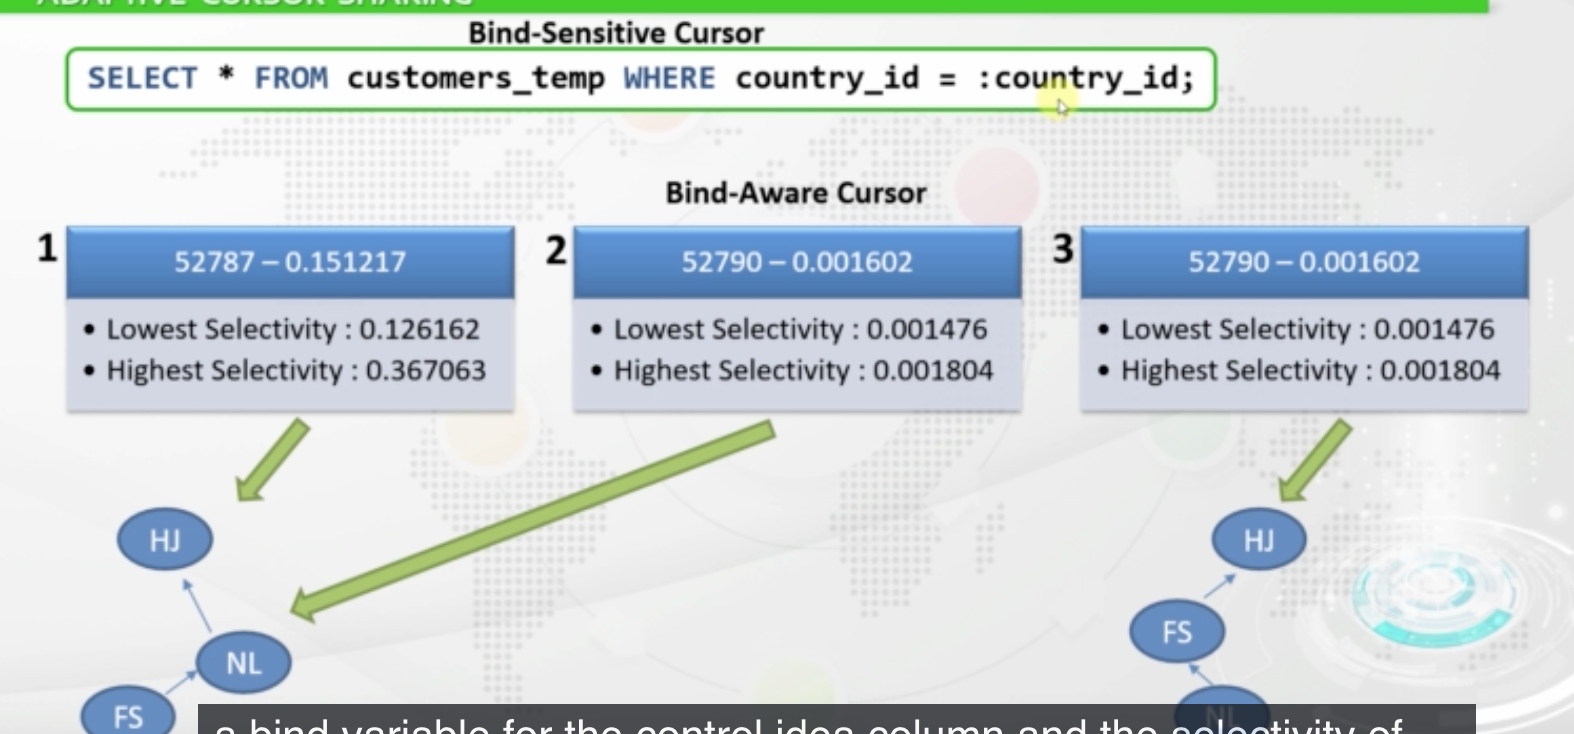

```sql
ALTER SYSTEM FLUSH SHARED_POOL;
 
 
SELECT COUNT(*),country_id FROM customers GROUP BY country_id order by count(*);
CREATE TABLE customers_temp AS SELECT * FROM customers;
CREATE INDEX cost_temp_country_id ON customers_temp(country_id);
 
BEGIN
dbms_stats.gather_table_stats(ownname => 'SH', tabname => 'CUSTOMERS_TEMP',
method_opt => 'for columns size 254 COUNTRY_ID', CASCADE=>TRUE);
END;
 
VARIABLE country_id NUMBER;
EXEC :country_id := 52787;
SELECT * FROM customers_temp WHERE country_id = :country_id;
EXEC :country_id := 52790;
SELECT * FROM customers_temp WHERE country_id = :country_id;
EXEC :country_id := 52770;
SELECT * FROM customers_temp WHERE country_id = :country_id;
EXEC :country_id := 52788;
SELECT * FROM customers_temp WHERE country_id = :country_id;
EXEC :country_id := 52790;
SELECT * FROM customers_temp WHERE country_id = :country_id;
 
SELECT * FROM TABLE(dbms_xplan.display_cursor(NULL,NULL,'TYPICAL +PEEKED_BINDS'));
 
SELECT sql_id,child_number,executions,loads,parse_calls,is_bind_sensitive,is_bind_aware,sql_text
FROM v$sql WHERE sql_text LIKE 'SELECT * FROM customers_temp WHERE country_id =%';
 
SELECT hash_value,sql_id,child_number,range_id,LOW,HIGH,predicate
FROM v$sql_cs_selectivity;
 
DROP TABLE customers_temp;
``` 

# Adaptive plans

```sql
ALTER SYSTEM FLUSH SHARED_POOL;
 
SELECT COUNT(*)
FROM sales S, products P, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id;
 
SELECT * FROM TABLE(dbms_xplan.display_cursor());
 
SELECT * FROM TABLE(dbms_xplan.display_cursor(FORMAT => 'adaptive'));
 
SELECT /*+ GATHER_PLAN_STATISTICS */COUNT(*)
FROM sales S, products P, customers C
WHERE S.prod_id = P.prod_id
AND S.cust_id = C.cust_id;
 
SELECT * FROM TABLE(dbms_xplan.display_cursor(FORMAT => 'adaptive allstats last'));
``` 

# Dynamic Statistics